# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from google.cloud import bigquery
import cloudvolume
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.stats import zscore
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm


import sys
sys.path.append('/Users/kperks/Documents/ell-connectome/efish_em/efish_em') # change this path to wherever the folder is on your computer. 

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest
import AnalysisCode as efish 

In [12]:
import igraph


In [13]:

print(cloudvolume.__version__)

11.1.0


In [55]:
cell_colors = efish.color_palette('cell')

In [56]:
cell_colors

{'sg1': '#B2D732',
 'sg2': '#FCCC1A',
 'grc': '#FEFE33',
 'smpl': '#8601AF',
 'mg1': '#00CBFF',
 'mg2': '#FB9902',
 'lf': '#FE2712',
 'lg': '#0247FE',
 'aff': '#ffc0cb'}

## Datapath settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [2]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json' # change this path to wherever the folder is on your computer. And make sure the paths in the file are correct for your computer
settings_dict = efish.import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

## Molecular layer fit

In [3]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json' # change this path to wherever the folder is on your computer. 

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)

set([item['name'] for item in neuroglancer_data['layers'] if item['type']=='annotation'])

nl_ = 'molecular'
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
voxel_sizes = [16,16,30]

vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']] #[p['point'] for p in neuroglancer_layer['annotations']]#

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

# Perform curve fitting
popt, pcov = curve_fit(efish.func_planar_curve, (x_pts, z_pts), y_pts)

# Print optimized parameters
print(popt)


[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]


## Load reconstruction files

In [5]:
dirpath =  Path(settings_dict['save_dir'])

nodefiles = efish.get_cell_filepaths(dirpath)

# cell types for all files in directory

## from file

In [6]:
df_type = pd.read_csv(dirpath / 'metadata/df_type_auto_typed.csv') # change this path to wherever the folder is on your computer. 

# Granule Cell Axons

## df_syn 

In [7]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv') # change this path to wherever the folder is on your computer. 
syn = 'post-synaptic'

In [12]:
'''
Add a column for unwarped y location (using molecular layer fit plane function)
'''

y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = efish.func_planar_curve((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

## add cell type to df_syn

In [8]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

# Completeness of synapses



In [40]:
syn = 'post-synaptic'
source = 'pre'

check_types = ['pe']#set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique())

df_progress = efish.check_annot_reconstruction_completeness(df_syn, nodefiles, df_type, syn, source, check_types)

In [43]:
df_progress[(df_progress['cell_type'].isin(['pe']))].sort_values('todo')# & (df_progress['todo']>0) #grc','sgx2','sg2','mg2

,id,cell_type,n_syn,done,todo,completed
3,183918283,pe,34,34,0,1.000000
4,530044972,pe,22,22,0,1.000000
5,295969408,pe,15,15,0,1.000000
7,642782594,pe,9,9,0,1.000000
9,618137237,pe,8,7,1,0.875000
8,386579108,pe,16,11,5,0.687500
2,630355985,pe,78,72,6,0.923077
1,638373058,pe,147,139,8,0.945578
6,31781654,pe,36,19,17,0.527778
0,285761792,pe,138,108,30,0.782609


# filter df_syn

## include only PE type presynaptic cells

In [9]:
mask = (df_syn['pre_type'].isin(['pe'])) #& (df_syn['pre'].isin([638373058,630355985,285761792]))
df_syn = df_syn[mask]

# --> create connection dataframe df_edges

In [10]:
df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

In [11]:
df_edges

,pre,post,pre_type,post_type,weight
0,285761792,134201244,pe,tsd,8
1,285761792,127672247,pe,mg2,7
2,638373058,212183617,pe,mli,7
3,638373058,126339859,pe,mli,6
4,638373058,42769344,pe,mg2,5
...,...,...,...,...,...
301,386579108,558313924,pe,sg2,1
302,530044972,38406507,pe,fov,1
303,530044972,40539602,pe,fov,1
304,530044972,40542265,pe,fov,1


# visualization in neuroglancer

In [28]:
viewer = neuroglancer.Viewer()

In [29]:
with viewer.txn(overwrite=True) as s:
    wb_open(str(viewer))

In [16]:
vx_sizes = [16, 16, 30]
import matplotlib

def get_viewer(backgnd_color = "black"):
    viewer = neuroglancer.Viewer()
    viewer.set_state({})

    location=[17000,17000,1500]

    with viewer.config_state.txn() as s:
        s.show_layer_panel = True ###

    with viewer.txn(overwrite=True) as s:

        dimensions = neuroglancer.CoordinateSpace(
            scales=vx_sizes,# self.vx_sizes['em'],
            units='nm',
            names=['x', 'y', 'z']   )

        s.showSlices = False
        s.dimensions = dimensions
        s.position = array(location)
        s.layout = "3d"
        s.projectionScale = 30000
        s.projection_background_color= matplotlib.colors.cnames[backgnd_color]#"#000000"
        # s.projection_background_color= "#ffffff"
        s.showSlices = False

    with viewer.txn(overwrite=True) as s:
        wb_open(str(viewer))
    
    return viewer

def bkgnd_color(viewer,backgnd_color):
    with viewer.txn(overwrite=True) as s:
        s.projection_background_color= matplotlib.colors.cnames[backgnd_color]

def create_baseseg_layer(viewer, lname, visible = False, objectAlpha = 1, source = 'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930'):
    with viewer.txn(overwrite=True) as s:
        s.layers[lname] = neuroglancer.SegmentationLayer(source = source, segments=[], segment_colors={})
        s.layers[lname].ignoreNullVisibleSet = False
        s.layers[lname].pick = True
        s.layers[lname].selectedAlpha = 0.5 #For 2D
        s.layers[lname].objectAlpha = objectAlpha
        s.layers[lname].visible = visible
                 

def create_em_layer(viewer, source = 'brainmaps://10393113184:ell:roi450um_xyz'):
    with viewer.txn(overwrite=True) as s:
        s.layers['em'] = neuroglancer.ImageLayer(source = source)


In [32]:
viewer = get_viewer(backgnd_color="white")

In [33]:
create_em_layer(viewer)

In [34]:
viewer = get_viewer(backgnd_color="white")
# create_em_layer(viewer)

dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network')

focal_cell_id = '393464000'
lname = focal_cell_id

create_baseseg_layer(viewer, lname, visible=True)

focal_cell_fname = nodefiles[focal_cell_id] # or rather than using the nodefiles dictionary, this can just be a file name from the folder specified by your dirpath 'cell_graph_214581797__2023-07-17 12.58.20.json'

cell_data = efish.load_ecrest_celldata(dirpath / focal_cell_fname)

with viewer.txn(overwrite=True) as s:
    for dtype in cell_data['base_segments'].keys():
        for bs in cell_data['base_segments'][dtype]:
            s.layers[lname].segments.add(int(bs))
            # s.layers[lname].segment_colors[int(bs)] = '#eeeeee'

In [25]:
cell_data.keys()


dict_keys(['graph_edges', 'graph_nodes', 'base_locations', 'added_graph_edges', 'added_graph_edges_pre_proofreading', 'end_points', 'base_seg_merge_points', 'removed_base_segs', 'anchor_seg', 'metadata', 'base_segments'])

In [27]:
cell_data['base_segments']

{'unknown': ['393480659',
  '393479959',
  '393465256',
  '392351200',
  '393478836',
  '393480892',
  '394625841',
  '393480208',
  '394594052',
  '392335022',
  '391204698',
  '394625351',
  '393465719',
  '393495026',
  '388914366',
  '391189908',
  '393481017',
  '308751704',
  '393463813',
  '393481278',
  '393464686',
  '394611632',
  '393494546',
  '393463975',
  '393495591',
  '307606944',
  '394623804',
  '393479479',
  '394625672',
  '393495437',
  '393449281',
  '393449273',
  '394608956',
  '393480134',
  '394625619',
  '394626581',
  '393496415',
  '393481129',
  '393481291',
  '393481210',
  '394626228',
  '394593948',
  '393496615',
  '394611354',
  '392334903',
  '393463861',
  '307606429',
  '307606442',
  '394611674',
  '394624676',
  '307621536',
  '394626790',
  '394611297',
  '394611607',
  '393481628',
  '307607206',
  '394624136',
  '394610183',
  '390043943',
  '393479060',
  '393479843',
  '393464471',
  '394624182',
  '392335172',
  '391189899',
  '393465056',

# Connection patterns

The code below analyzes all postsynaptic cell types. If you want to include only a subset of postsynaptic types, you can use 'masking' on the dataframe before analyzing.


For example:
<code>
mask = df_syn['post_type'].isin(['lf','lg','mg1','mg2','sg1','sg2','mli'])  
df_pie = df_syn[mask].groupby('post_type')['post'].count().reset_index()
</code> 

## pie chart

In [17]:
df_pie = df_syn.groupby('post_type')['post'].count().reset_index()
df_pie['post_frac'] = (df_pie["post"] / df_pie["post"].sum()) 

# Define custom order
order = ['lg','mg1','sg1','lf','mg2','sg2']
# Set 'post_type' as a categorical column with the desired order
df_pie['post_type'] = pd.Categorical(df_pie['post_type'], categories=order, ordered=True)

# Sort by the categorical column
df_pie = df_pie.sort_values('post_type')
df_pie

,post_type,post,post_frac
1,lg,63,0.096923
2,mg1,173,0.266154
4,sg1,77,0.118462
0,lf,82,0.126154
3,mg2,194,0.298462
5,sg2,61,0.093846


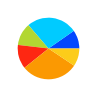

In [19]:
plt.figure(figsize=(1,1))
ax = plt.gca()
plt.pie(df_pie['post'], colors=[cell_colors[key] for key in df_pie['post_type']], 
                      wedgeprops=dict(edgecolor='none'),
                      startangle=0)
ax.set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


## stacked bar per pre cell

In [54]:
df_edges['post_type'].unique()

array(['tsd', 'mg2', 'mli', 'sg2', 'mg1', 'lg', 'sg1', 'smpl', 'fov', 'h',
       'uk', 'lf', 'sgx2'], dtype=object)

In [57]:
count_type = 'nsyn' # 'ncells' #
mask = df_edges['post_type'].isin(df_edges['post_type'].unique())#(df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf','mli']))#,'mli','tsd','dml'])) # 

if count_type == 'nsyn':
    df_map = df_edges[mask].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()

if count_type == 'ncells':
    df_map = df_edges[mask].groupby(
        ['pre','pre_type','post_type']).count().reset_index().pivot(
        index='pre', columns='post_type', values='post').fillna(0).reset_index()

df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')

In [61]:
df_map

post_type,fov,h,lf,lg,mg1,mg2,mli,sg1,sg2,sgx2,smpl,tsd,uk
pre,,,,,,,,,,,,,
31781654,6.0,0.0,3.0,0.0,2.0,5.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
183918283,3.0,0.0,2.0,0.0,0.0,8.0,6.0,1.0,7.0,0.0,2.0,3.0,2.0
285761792,1.0,0.0,5.0,2.0,5.0,27.0,16.0,6.0,28.0,0.0,2.0,10.0,6.0
295969408,0.0,2.0,0.0,4.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0
386579108,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,0.0,1.0,0.0
530044972,3.0,0.0,2.0,0.0,0.0,6.0,5.0,1.0,1.0,0.0,1.0,2.0,1.0
618137237,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
630355985,7.0,0.0,1.0,0.0,15.0,21.0,0.0,13.0,11.0,1.0,0.0,0.0,3.0
638373058,20.0,0.0,6.0,0.0,0.0,28.0,35.0,2.0,19.0,0.0,6.0,15.0,8.0


In [27]:
target_order = ['mg1','lg','sg1','mg2','lf','sg2','mli']#['lg','mg1','sg1','lf','mg2','sg2']#
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]


In [28]:
mg1_map = df_map[df_map['mg1']>0].sort_values(['mg1'],ascending=False)

mg2_map = df_map[~df_map.index.isin(mg1_map.index)].sort_values(['mg2'])

sorted_full = pd.concat([mg1_map,mg2_map])


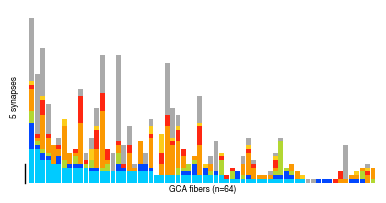

In [29]:
# Plotting
''' change axis limits and labels as needed'''
fig, ax = plt.subplots(figsize=(4.5, 2.25))
# Create a stacked bar plot
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = cell_colors,ax=ax, width=0.9,legend=False,edgecolor='none')
ax.set_xticks([])
ax.set_yticks([0,5])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', length=0)
sns.despine(bottom=True,trim=True,offset=2)
ax.set_ylabel('5 synapses') # this needs to match diff between ylims
ax.set_xlabel(f'PE fibers (n={len(sorted_full)})')
# ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')

In [60]:
df_map

post_type,fov,h,lf,lg,mg1,mg2,mli,sg1,sg2,sgx2,smpl,tsd,uk
pre,,,,,,,,,,,,,
31781654,6.0,0.0,3.0,0.0,2.0,5.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
183918283,3.0,0.0,2.0,0.0,0.0,8.0,6.0,1.0,7.0,0.0,2.0,3.0,2.0
285761792,1.0,0.0,5.0,2.0,5.0,27.0,16.0,6.0,28.0,0.0,2.0,10.0,6.0
295969408,0.0,2.0,0.0,4.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0
386579108,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,0.0,1.0,0.0
530044972,3.0,0.0,2.0,0.0,0.0,6.0,5.0,1.0,1.0,0.0,1.0,2.0,1.0
618137237,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
630355985,7.0,0.0,1.0,0.0,15.0,21.0,0.0,13.0,11.0,1.0,0.0,0.0,3.0
638373058,20.0,0.0,6.0,0.0,0.0,28.0,35.0,2.0,19.0,0.0,6.0,15.0,8.0


<AxesSubplot:xlabel='pre'>

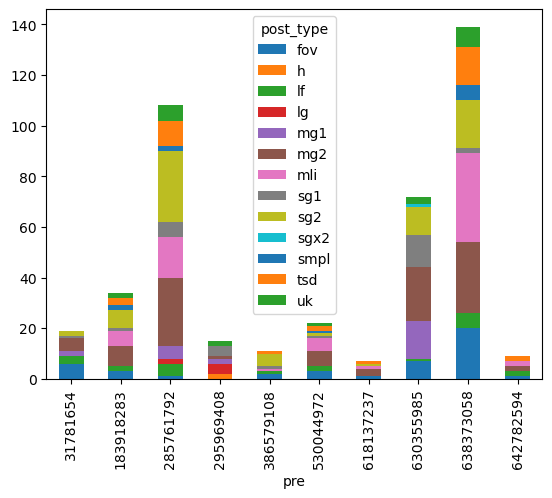

In [59]:
df_map.plot.bar(stacked=True)

## conditional OUTPUT analysis

In [68]:
def get_conditional_output(df_syn,order, normalize=False):
    '''get p(connect)'''
    df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')
    df_map = df_edges.groupby(['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='pre', columns='post_type', values='weight').fillna(0).reset_index().set_index('pre')
    df_map = df_map[order]

    result = []
    for g in df_map.columns:
        # g = 'aff'
        df_sub = deepcopy(df_map[(df_map[g] > 0)])
        df_sub.loc[:,g] = df_sub[g].values-1 # subtract the one connection that qualifies this cell as getting input from g type

        if normalize==True:
            df_sub = df_sub.div(df_sub.sum(axis=1),axis=0)

        result.append(list(df_sub.mean().values)) 

    order = df_map.columns
        
    return result,order


In [69]:
pre_groups = ['pe']
post_groups = ['sg1','mg1','lg','sg2','mg2','lf'] # change the postsynaptic cell type set as needed

In [70]:
df_counts = df_syn.groupby(['pre'])['post'].count().reset_index()

'''
if want to, can restrict the analysis to a certain range of connectivity 'strengths':
''' 
# pre_highsyn = df_counts[df_counts['post']>4]['pre'].values
# pre_lowsyn = df_counts[df_counts['post']<20]['pre'].values

In [92]:
mask = df_syn['pre_type'].isin(pre_groups) & df_syn['post_type'].isin(post_groups) #& \
    #df_syn['pre'].isin(pre_highsyn) #& df_syn['pre'].isin(pre_lowsyn)  # Filter out rows with post_type not in post_types_order and pre_tyep not in 

### shuffle result

In [79]:
result_shuff = []

# Iterate the specified number of times
for i in range(100):
    
    df_syn_shuff = efish.shuffle_synapses(df_syn[mask],['post','post_type']) #post ID must travel in syn table with its ID for the rest of the analysis to work

    result_,order = get_conditional_output(df_syn_shuff,order = post_groups, normalize=True)
    result_ = np.asarray(result_)
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)
u_mat = result_shuff.mean(axis=0)
std_mat = result_shuff.std(axis=0)

### data

In [80]:
result_data,order = get_conditional_output(df_syn[mask], order = post_groups,normalize=True)

# Calculate the z-scores
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero

cond_input_mat = pd.DataFrame(z_scores,columns = order, index = order)

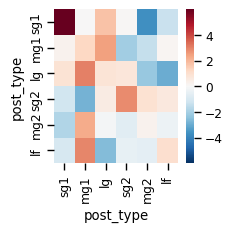

In [82]:
# Ensure the color range is centered around 0
vmin = -max(abs(cond_input_mat.min().min()), abs(cond_input_mat.max().max()))
vmax = -vmin

sns.set_context("paper",font_scale=1)
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(cond_input_mat,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)


### an example of shuffle result

<AxesSubplot:xlabel='post_type', ylabel='post_type'>

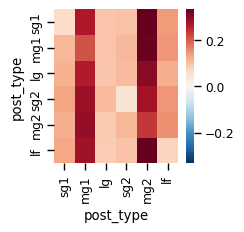

In [95]:

df_syn_shuff = efish.shuffle_synapses(df_syn[mask],['post','post_type']) #post ID must travel in syn table with its ID for the rest of the analysis to work

result_,order = get_conditional_output(df_syn_shuff,order = post_groups, normalize=True)
result_ = np.asarray(result_)

cond_input_mat = pd.DataFrame(result_,columns = order, index = order)

# Ensure the color range is centered around 0
vmin = -max(abs(cond_input_mat.min().min()), abs(cond_input_mat.max().max()))
vmax = -vmin

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(cond_input_mat,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0, ax=ax)